In [1]:
#--------------------------------68-------------------------------->

In [2]:
# imports
import os
import sys
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import (
    AnchoredSizeBar as scalebar
)
from collections import Counter as counter
import scipy.stats as st
from scipy.ndimage import gaussian_filter as gauss
import copy
import astropy.stats as stats
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
import pandas as pd
import imageio
import time

# # LSST stack setup
# import lsst
# import lsst.daf.persistence as dafPersist
# import lsst.afw.display as afwDisplay
# from lsst.ip.isr import IsrTask
# import lsst.afw.detection as afwDetection
# import lsst.afw.image as afwImage
# import lsst.afw.geom as afwGeom
# ! echo 'LSST stack version: ' & eups list -s lsst_distrib

# # LSK imports
# from lskfunctions import *

# Notebook startup
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
print(f'Notebook run time: \n   {time.ctime()}')
#--------------------------------68-------------------------------->

Notebook run time: 
   Tue Jun 16 02:08:27 2020


In [3]:
# # params
# data_file = 'GAMA_fits/gama_to_debias.fits'
# output_directory = 'output_files/'

# logistic_bounds = ((0.5,10), (-10, 10))
# exponential_bounds = ((10**(-5),10),(10**(-5),10)) 

# log_fv_range = (-1.5,0.01)
# count_suffix = '_total_raw'
# fraction_suffix = '_frac'

# Mr_column = 'absmag_r'
# R50_column = 'GALRE_r_kpc'
# z_column = 'Z_TONRY'

# n_voronoi = 30
# n_per_z = 50
# low_signal_limit = 100
# clip_percentile = 5 

# volume_redshift_limits = (0.03,0.10)
# survey_mag_limit = 19.8

In [4]:
# z to dist
def z_to_dist(z):
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    return cosmo.luminosity_distance(z)

In [5]:
# mag to Mag
def mag_to_Mag(mag, z):
    import astropy.units as u
    D = z_to_dist(z)
    Mag = mag - 5*(np.log10(D/(u.pc))-1)
    return Mag

In [6]:
# data_select imports
# from astropy.table import Table, column
# sys.path.append('../astro_codes/')

In [7]:
# gama tabular data
gama_cln = Table.read('../gz_gama_2018-02-25_cleaned.fits.gz')
gama_bin = Table.read('../gz_gama_2018-02-25_binned.fits.gz')
gama_ext = Table.read('../../inputs/manifest/gamazoo_extra.fits.gz')

In [8]:
# add original binned total counts to cleaned catalogue
N_names = [c for c in gama_bin.colnames if 'total' in c]
for n in N_names:
    gama_cln[n + '_bin'] = gama_bin[n]

In [9]:
# generate gama_data table
R50 = gama_ext['GALRE_r_kpc']
Mr = gama_ext['absmag_r']

R_ok = np.all([R50 > 0, R50 < 20], axis=0)
Mr_ok = np.all([Mr < -10, Mr > -25], axis=0)
data_ok = (R_ok) & (Mr_ok)

gama_data = gama_cln[data_ok]
for c in ('absmag_r', 'GALRE_r_kpc', 'Z_TONRY'):
    gama_data[c] = gama_ext[data_ok][c] 

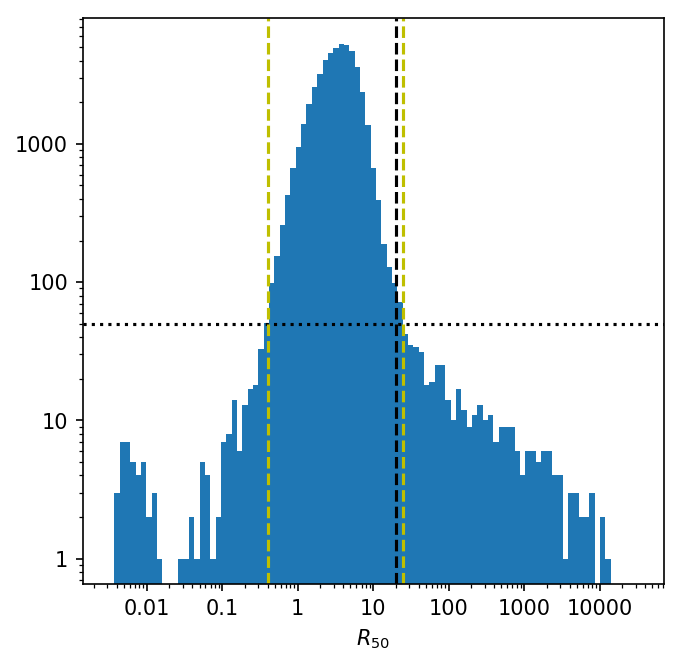

In [10]:
# R50 analysis plot
fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.subplot(111)

ax.hist(R50, bins=np.logspace(-2.5, 4.5, 100))
ax.loglog()
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
plt.axhline(50, c='k', ls='dotted')
plt.axvline(20, c='k', ls='--')
plt.axvline(0.4, c='y', ls='--')
plt.axvline(25, c='y', ls='--')
ax.set_xlabel('$R_{50}$')

plt.show()
plt.close()

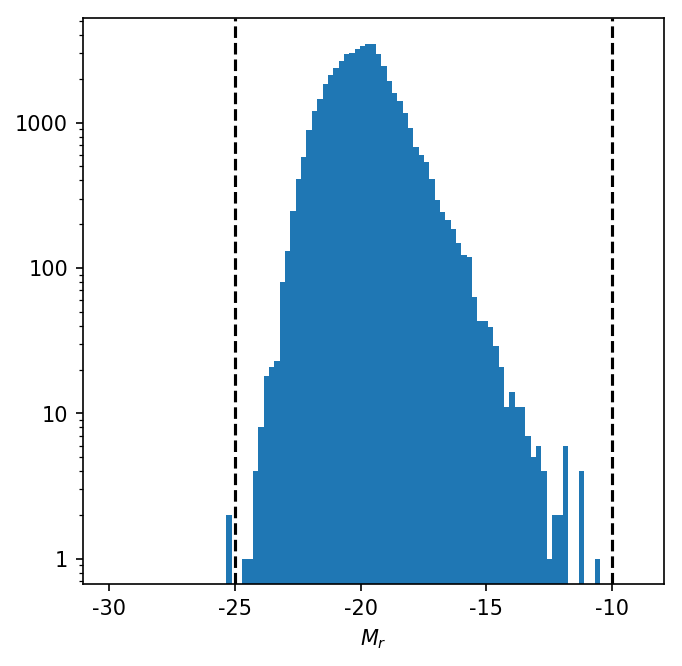

In [11]:
# Mr analysis plot
fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.subplot(111)

ax.hist(Mr, bins=np.linspace(-30,-9,100), log=True)
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
plt.axvline(-10, c='k', ls='--')
plt.axvline(-25, c='k', ls='--')
ax.set_xlabel('$M_r$')

plt.show()
plt.close()

In [12]:
def kde2d(x, y, 
          xmin=None, xmax=None, xstep=50j, xlog=False,
          ymin=None, ymax=None, ystep=50j, ylog=False):
    import numpy as np
    import scipy.stats as st
    old = np.seterr(invalid='ignore')
    xmin = np.nanmin(x) if xmin is None else xmin
    xmax = np.nanmax(x) if xmax is None else xmax
    ymin = np.nanmin(y) if ymin is None else ymin
    ymax = np.nanmax(y) if ymax is None else ymax
    if xlog:
        x = np.log10(x)
        xmin = np.log10(xmin)
        xmax = np.log10(xmax)
    if ylog:
        y = np.log10(y)
        ymin = np.log10(ymin)
        ymax = np.log10(ymax)
    good = ~(np.isnan(x) | np.isnan(y))
    x = x[good]
    y = y[good]
    X, Y = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    if xlog:
        X = 10**X
    if ylog:
        Y = 10**Y
    np.seterr(**old)
    return X, Y, Z

In [13]:
# generate kernel density estimates
X, Y, Z = kde2d(R50, Mr, xmin=0.1, xmax=100, xlog=True, xstep=50j,
                ymin=-5, ymax=-30, ystep=50j)
levels = 10**np.mgrid[np.log10(np.max(Z))-1:np.log10(np.max(Z)):10j]
levels = levels[:-1]

49243/49866 have reasonable sizes and brightnesses


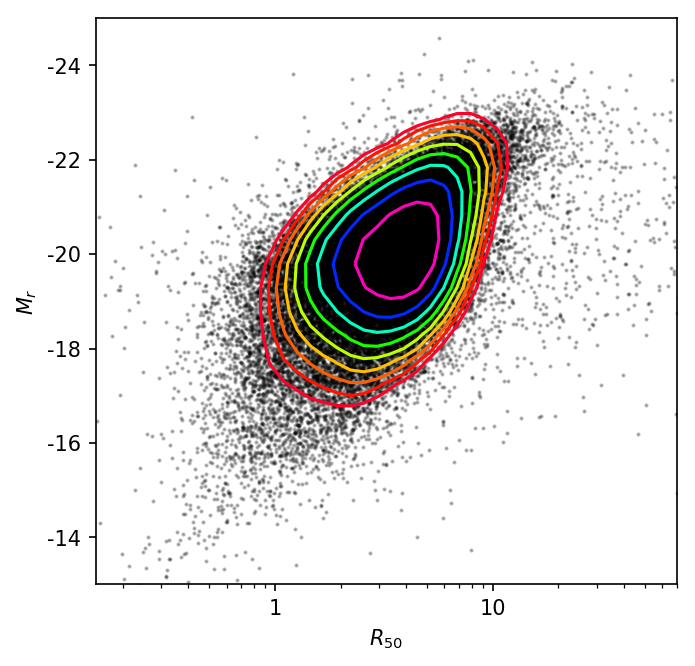

In [14]:
# gama_data analysis plot

print(f'{data_ok.sum()}/{len(data_ok)} have reasonable sizes and '
      f'brightnesses')

fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.subplot(111)

ax.scatter(R50, Mr, color='k', s=1, alpha=0.25)
ax.contour(X, Y, Z, levels=levels, cmap='gist_rainbow')
ax.set_xscale('log')
ax.set_xlim(0.15, 70)
ax.set_ylim(-13, -25)
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_xlabel('$R_{50}$')
ax.set_ylabel('$M_r$')

plt.show()
plt.close()

M_r (limit) = -18.515204574390932


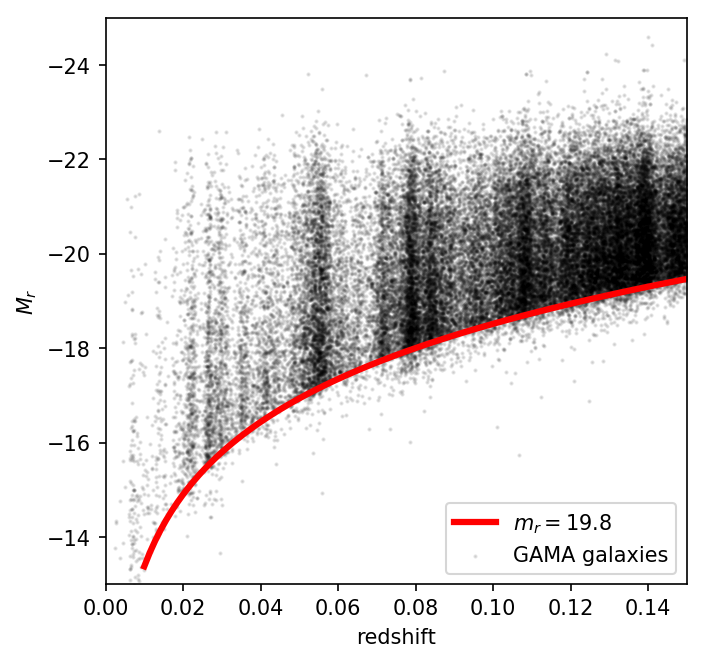

In [15]:
# redshift-magnitude diagram
zs = np.linspace(0.01, 0.15, 100)
Mags = mag_to_Mag(19.8, zs)
Mag_limit = mag_to_Mag(19.8, 0.1)
print(f'M_r (limit) = {Mag_limit}')

fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.subplot(111)

plt.scatter(gama_data['Z_TONRY'], gama_data['absmag_r'], 
            color='k', s=1, label='GAMA galaxies', alpha=0.1)
plt.plot(zs, Mags, color='r', label='$m_r=19.8$', lw=3)
plt.xlabel('redshift')
plt.ylabel('$M_r$')
plt.legend(loc='lower right')

plt.axis((0,0.15,-13,-25))

plt.show()
plt.close()

In [16]:
#--------------------------------68-------------------------------->